Credit Risk Model - by Koyalkar Chetan 24MBMB20

Objective: Predict whether a customer will default on their next payment using PySpark ML which is critical for banks to manage risk and maintain profitability.

The solution methodology outlines our approach for predicting whether a customer experiment will result in default or not, and we employ the following machine learning algorithms like Logistic Regression, Support Vector Machines, Random Forest, Decision Tree, and K-Means clustering

In [0]:
# Initialize Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CreditRiskModeling").getOrCreate()




In [0]:
# Load data into Databricks environment

file_location = "/Volumes/workspace/default/mydatasets/UCI_Credit_Card.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

row_count = data.count()
print("There are %d rows in the data set." % (row_count))


There are 30000 rows in the data set.


In [0]:
# Print Schema
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2: double (nullable = true)
 |-- BILL_AMT3: double (nullable = true)
 |-- BILL_AMT4: double (nullable = true)
 |-- BILL_AMT5: double (nullable = true)
 |-- BILL_AMT6: double (nullable = true)
 |-- PAY_AMT1: double (nullable = true)
 |-- PAY_AMT2: double (nullable = true)
 |-- PAY_AMT3: double (nullable = true)
 |-- PAY_AMT4: double (nullable = true)
 |-- PAY_AMT5: double (nullable = true)
 |-- PAY_AMT6: double (nullable = true)
 |-- default.payment.next.month: integer (nullable

In [0]:
# Rename columns for clarity
from pyspark.sql.functions import col

data = data.withColumnRenamed("PAY_0", "pay_1")
data = data.withColumnRenamed("default.payment.next.month", "default_pay")
# Rename other columns as needed


In [0]:
temp_table_name="creditdata_csv"
data.createOrReplaceTempView(temp_table_name)
print("Temporary view '{}' created successfully.".format(temp_table_name))

Temporary view 'creditdata_csv' created successfully.


In [0]:
%sql
describe table creditdata_csv

col_name data_type comment ID int null LIMIT_BAL double null SEX int null EDUCATION int null MARRIAGE int null AGE int null pay_1 int null PAY_2 int null PAY_3 int null PAY_4 int null PAY_5 int null PAY_6 int null BILL_AMT1 double null BILL_AMT2 double null BILL_AMT3 double null BILL_AMT4 double null BILL_AMT5 double null BILL_AMT6 double null PAY_AMT1 double null PAY_AMT2 double null PAY_AMT3 double null PAY_AMT4 double null PAY_AMT5 double null PAY_AMT6 double null default_pay int null

In [0]:
# Mapping categorical values
from pyspark.sql.functions import when

#gender mapping
gender_mapping = {1: "male", 2: "female"}
data = data.withColumn("SEX", when(col("SEX") == 1, "male").otherwise("female"))

#education mapping
education_mapping = {
    1: "graduate school", 
    2: "university", 
    3: "high school", 
    4: "others",
    5: "unknown",
    6: "unknown"
    }

data = data.withColumn(
    "EDUCATION",
    when(col("EDUCATION") == 1, "graduate school")
    .when(col("EDUCATION") == 2, "university")
    .when(col("EDUCATION") == 3, "high school")
    .when(col("EDUCATION") == 4, "others")
    .when(col("EDUCATION") == 5, "unknown")
    .when(col("EDUCATION") == 6, "unknown").otherwise("unknown")
    )
    
#marriage mapping
marriage_mapping = {1: "married", 2: "single", 3: "others"}

data = data.withColumn(
    "MARRIAGE",
    when(col("MARRIAGE") == 1, "married")
    .when(col("MARRIAGE") == 2, "single")
    .otherwise("others")
)


In [0]:
#displaying first 4 rows for inspection
data.show(4)





+---+---------+------+----------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+
| ID|LIMIT_BAL|   SEX| EDUCATION|MARRIAGE|AGE|pay_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_pay|
+---+---------+------+----------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+
|  1|  20000.0|female|university| married| 24|    2|    2|   -1|   -1|   -2|   -2|   3913.0|   3102.0|    689.0|      0.0|      0.0|      0.0|     0.0|   689.0|     0.0|     0.0|     0.0|     0.0|          1|
|  2| 120000.0|female|university|  single| 26|   -1|    2|    0|    0|    0|    2|   2682.0|   1725.0|   2682.0|   3272.0|   3455.0|   3261.0|     0.0|  1000.0|  10

In [0]:
#creating a temporary view for the data exploration
data.createOrReplaceTempView("exploretable")

In [0]:
%sql
select * from exploretable

ID LIMIT_BAL SEX EDUCATION MARRIAGE AGE pay_1 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6 default_pay 1 20000.0 female university married 24 2 2 -1 -1 -2 -2 3913.0 3102.0 689.0 0.0 0.0 0.0 0.0 689.0 0.0 0.0 0.0 0.0 1 2 120000.0 female university single 26 -1 2 0 0 0 2 2682.0 1725.0 2682.0 3272.0 3455.0 3261.0 0.0 1000.0 1000.0 1000.0 0.0 2000.0 1 3 90000.0 female university single 34 0 0 0 0 0 0 29239.0 14027.0 13559.0 14331.0 14948.0 15549.0 1518.0 1500.0 1000.0 1000.0 1000.0 5000.0 0 4 50000.0 female university married 37 0 0 0 0 0 0 46990.0 48233.0 49291.0 28314.0 28959.0 29547.0 2000.0 2019.0 1200.0 1100.0 1069.0 1000.0 0 5 50000.0 male university married 57 -1 0 -1 0 0 0 8617.0 5670.0 35835.0 20940.0 19146.0 19131.0 2000.0 36681.0 10000.0 9000.0 689.0 679.0 0 6 50000.0 male graduate school single 37 0 0 0 0 0 0 64400.0 57069.0 57608.0 19394.0 19619.0 20024.0 2500.0 1815.0 657.0 1000.0 1000.0 800.0 0 7 500000.0 male graduate school single 29 0 0 0 0 0 0 367965.0 412023.0 445007.0 542653.0 483003.0 473944.0 55000.0 40000.0 38000.0 20239.0 13750.0 13770.0 0 8 100000.0 female university single 23 0 -1 -1 0 0 -1 11876.0 380.0 601.0 221.0 -159.0 567.0 380.0 601.0 0.0 581.0 1687.0 1542.0 0 9 140000.0 female high school married 28 0 0 2 0 0 0 11285.0 14096.0 12108.0 12211.0 11793.0 3719.0 3329.0 0.0 432.0 1000.0 1000.0 1000.0 0 10 20000.0 male high school single 35 -2 -2 -2 -2 -1 -1 0.0 0.0 0.0 0.0 13007.0 13912.0 0.0 0.0 0.0 13007.0 1122.0 0.0 0 11 200000.0 female high school single 34 0 0 2 0 0 -1 11073.0 9787.0 5535.0 2513.0 1828.0 3731.0 2306.0 12.0 50.0 300.0 3738.0 66.0 0 12 260000.0 female graduate school single 51 -1 -1 -1 -1 -1 2 12261.0 21670.0 9966.0 8517.0 22287.0 13668.0 21818.0 9966.0 8583.0 22301.0 0.0 3640.0 0 13 630000.0 female university single 41 -1 0 -1 -1 -1 -1 12137.0 6500.0 6500.0 6500.0 6500.0 2870.0 1000.0 6500.0 6500.0 6500.0 2870.0 0.0 0 14 70000.0 male university single 30 1 2 2 0 0 2 65802.0 67369.0 65701.0 66782.0 36137.0 36894.0 3200.0 0.0 3000.0 3000.0 1500.0 0.0 1 15 250000.0 male graduate school single 29 0 0 0 0 0 0 70887.0 67060.0 63561.0 59696.0 56875.0 55512.0 3000.0 3000.0 3000.0 3000.0 3000.0 3000.0 0 16 50000.0 female high school others 23 1 2 0 0 0 0 50614.0 29173.0 28116.0 28771.0 29531.0 30211.0 0.0 1500.0 1100.0 1200.0 1300.0 1100.0 0 17 20000.0 male graduate school single 24 0 0 2 2 2 2 15376.0 18010.0 17428.0 18338.0 17905.0 19104.0 3200.0 0.0 1500.0 0.0 1650.0 0.0 1 18 320000.0 male graduate school married 49 0 0 0 -1 -1 -1 253286.0 246536.0 194663.0 70074.0 5856.0 195599.0 10358.0 10000.0 75940.0 20000.0 195599.0 50000.0 0 19 360000.0 female graduate school married 49 1 -2 -2 -2 -2 -2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0 20 180000.0 female graduate school single 29 1 -2 -2 -2 -2 -2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0 21 130000.0 female high school single 39 0 0 0 0 0 -1 38358.0 27688.0 24489.0 20616.0 11802.0 930.0 3000.0 1537.0 1000.0 2000.0 930.0 33764.0 0 22 120000.0 female university married 39 -1 -1 -1 -1 -1 -1 316.0 316.0 316.0 0.0 632.0 316.0 316.0 316.0 0.0 632.0 316.0 0.0 1 23 70000.0 female university single 26 2 0 0 2 2 2 41087.0 42445.0 45020.0 44006.0 46905.0 46012.0 2007.0 3582.0 0.0 3601.0 0.0 1820.0 1 24 450000.0 female graduate school married 40 -2 -2 -2 -2 -2 -2 5512.0 19420.0 1473.0 560.0 0.0 0.0 19428.0 1473.0 560.0 0.0 0.0 1128.0 1 25 90000.0 male graduate school single 23 0 0 0 -1 0 0 4744.0 7070.0 0.0 5398.0 6360.0 8292.0 5757.0 0.0 5398.0 1200.0 2045.0 2000.0 0 26 50000.0 male high school single 23 0 0 0 0 0 0 47620.0 41810.0 36023.0 28967.0 29829.0 30046.0 1973.0 1426.0 1001.0 1432.0 1062.0 997.0 0 27 60000.0 male graduate school single 27 1 -2 -1 -1 -1 -1 -109.0 -425.0 259.0 -57.0 127.0 -189.0 0.0 1000.0 0.0 500.0 0.0 1000.0 1 28 50000.0 female high school single 30 0 0 0 0 0 0 22541.0 16138.0 17163.0 17878.0 18931.0 19617.0 1300.0

In [0]:
from pyspark.sql.functions import col, isnan, when, count

# Identify numeric columns
numeric_types = ["double", "float", "int", "bigint", "smallint", "tinyint", "decimal", "long", "short"]
numeric_cols = [c for c, t in data.dtypes if t in numeric_types]

# Build expressions for null/NaN counting
exprs = [
    count(
        when(
            (isnan(c) | col(c).isNull()) if c in numeric_cols else col(c).isNull(),
            c
        )
    ).alias(c)
    for c in data.columns
]

Number_of_nulls = data.select(exprs)

if all(count == 0 for count in Number_of_nulls.first()):
    print("There are no null values in the dataset.")
    display(Number_of_nulls)
else:
    print("There are null values in the dataset.")

There are no null values in the dataset.


ID LIMIT_BAL SEX EDUCATION MARRIAGE AGE pay_1 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6 default_pay 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [0]:
#counting the number of clients by gender
gender_count = data.groupBy("SEX").count()
display(gender_count)

#counting the number of clients by education
education_count = data.groupBy("EDUCATION").count()
display(education_count)

#counting the number of clients by marital status
marriage_count = data.groupBy("MARRIAGE").count()
display(marriage_count)

#counting the number of clients by marriage status (ordered)
marriage_count_ordered = data.groupBy("MARRIAGE").count().orderBy("MARRIAGE")
display(marriage_count_ordered)



SEX count male 11888 female 18112

Databricks visualization. Run in Databricks to view.

EDUCATION count high school 4917 unknown 345 university 14030 others 123 graduate school 10585

Databricks visualization. Run in Databricks to view.

MARRIAGE count married 13659 single 15964 others 377

Databricks visualization. Run in Databricks to view.

MARRIAGE count married 13659 others 377 single 15964

In [0]:
#counting the number of default payments by education level
default_payments_by_education = data.groupBy("EDUCATION", "default_pay").count().orderBy("EDUCATION").filter(col("default_pay") == 1)
display(default_payments_by_education)

#displaying distinct ages in ascending order
distinct_ages = data.select("AGE").distinct().orderBy("AGE")
display(distinct_ages)

EDUCATION default_pay count graduate school 1 2036 high school 1 1237 others 1 7 university 1 3330 unknown 1 26

Databricks visualization. Run in Databricks to view.

AGE 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 79

Data preprocessing

pipeline transformation: Indexing Categorical Columns

In [0]:
# Convert the temporary view to a Spark DataFrame
df = spark.sql("SELECT * FROM exploretable")

In [0]:
df.show(5)

+---+---------+------+----------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+
| ID|LIMIT_BAL|   SEX| EDUCATION|MARRIAGE|AGE|pay_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_pay|
+---+---------+------+----------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----------+
|  1|  20000.0|female|university| married| 24|    2|    2|   -1|   -1|   -2|   -2|   3913.0|   3102.0|    689.0|      0.0|      0.0|      0.0|     0.0|   689.0|     0.0|     0.0|     0.0|     0.0|          1|
|  2| 120000.0|female|university|  single| 26|   -1|    2|    0|    0|    0|    2|   2682.0|   1725.0|   2682.0|   3272.0|   3455.0|   3261.0|     0.0|  1000.0|  10

In [0]:
# Databricks-safe validation (run this BEFORE the pipeline cell)
# 1) spark sanity checks (Databricks provides `spark` automatically)
print("spark object:", spark)            # should show a SparkSession object
print("spark version:", spark.version)
spark.sql("SELECT 1 AS ok").show()       # simple SQL check

# 2) Ensure df is a Spark DataFrame, convert if it's pandas
import pandas as pd
from pyspark.sql import DataFrame as SparkDataFrame

if 'df' not in globals():
    raise NameError("DataFrame `df` not found in this notebook. Load/create df before running the pipeline.")

if isinstance(df, pd.DataFrame):
    print("Detected pandas DataFrame; converting to Spark DataFrame now...")
    df = spark.createDataFrame(df)
else:
    print("df type:", type(df))

# 3) Column & schema checks
print("Columns:", df.columns)
df.printSchema()
df.show(5)


spark object: <pyspark.sql.connect.session.SparkSession object at 0xff6e74405370>
spark version: 4.0.0
+---+
| ok|
+---+
|  1|
+---+

df type: <class 'pyspark.sql.connect.dataframe.DataFrame'>
Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'pay_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_pay']
root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: string (nullable = false)
 |-- EDUCATION: string (nullable = false)
 |-- MARRIAGE: string (nullable = false)
 |-- AGE: integer (nullable = true)
 |-- pay_1: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2:

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
df_indexed = df  # keep original variable name if you like

for col in cat_cols:
    # ensure string type
    df_indexed = df_indexed.withColumn(col, F.col(col).cast("string"))

    # 1) get frequencies
    freq = df_indexed.groupBy(col).count()

    # 2) rank by frequency desc (most frequent -> index 0)
    w = Window.orderBy(F.desc("count"))
    mapping = freq.withColumn(f"{col}_index", F.row_number().over(w) - 1).select(col, f"{col}_index")

    # 3) left join mapping back to df
    # (use broadcast if mapping is tiny: from pyspark.sql.functions import broadcast)
    df_indexed = df_indexed.join(mapping, on=col, how="left")

    # 4) unseen / null -> -1 (mimic handleInvalid="keep")
    df_indexed = df_indexed.fillna({f"{col}_index": -1})

# show result
display(df_indexed.select("SEX","SEX_index","EDUCATION","EDUCATION_index","MARRIAGE","MARRIAGE_index").limit(10))


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


SEX SEX_index EDUCATION EDUCATION_index MARRIAGE MARRIAGE_index female 0 university 0 married 1 female 0 university 0 single 0 female 0 university 0 single 0 female 0 university 0 married 1 male 1 university 0 married 1 male 1 graduate school 1 single 0 male 1 graduate school 1 single 0 female 0 university 0 single 0 female 0 high school 2 married 1 male 1 high school 2 single 0

In [0]:
# Pick features (indexed categorical + numeric features)
# Exclude ID and target column 'default_pay'
cat_index_cols = ["SEX_index", "EDUCATION_index", "MARRIAGE_index"]
num_cols = [
    "LIMIT_BAL", "AGE", "pay_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
    "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"
]
label_col = "default_pay"

features = cat_index_cols + num_cols

# Quick schema & null checks
print("Feature count:", len(features))
print("Label:", label_col)
for c in features + [label_col]:
    if c not in df_indexed.columns:
        raise KeyError(f"Column {c} not found in DataFrame columns: {df_indexed.columns}")

# Optionally drop rows with null label
df_clean = df_indexed.na.drop(subset=[label_col])
print("Rows before:", df_indexed.count(), "after dropping null label:", df_clean.count())


Feature count: 23
Label: default_pay


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Rows before: 30000 after dropping null label: 30000


In [0]:
# If dataset is large, sample down to a manageable size to avoid OOM
MAX_ROWS = 150000   # tune depending on workspace memory
nrows = df_clean.count()
print("Total rows:", nrows)

if nrows > MAX_ROWS:
    print(f"Sampling down to {MAX_ROWS} rows for local sklearn training")
    # stratified sampling by label if needed:
    fraction = MAX_ROWS / float(nrows)
    df_sample = df_clean.sample(fraction=fraction, seed=42)
else:
    df_sample = df_clean

# Select features + label and convert to pandas
spark_selected = df_sample.select(features + [label_col])
pdf = spark_selected.toPandas()

print("Pandas shape:", pdf.shape)
pdf.head()


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Total rows: 30000
Pandas shape: (30000, 24)


SEX_index  EDUCATION_index  MARRIAGE_index  ...  PAY_AMT5  PAY_AMT6  default_pay
0          0                0               1  ...       0.0       0.0            1
1          0                0               0  ...       0.0    2000.0            1
2          0                0               0  ...    1000.0    5000.0            0
3          0                0               1  ...    1069.0    1000.0            0
4          1                0               1  ...     689.0     679.0            0

[5 rows x 24 columns]

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X = pdf[features].astype(float).values   # ensure floats
y = pdf[label_col].astype(int).values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features (fit scaler on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (24000, 23) Test size: (6000, 23)


In [0]:
from collections import Counter

print("Train label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

Train label distribution: Counter({0: 18691, 1: 5309})
Test label distribution: Counter({0: 4673, 1: 1327})


In [0]:
#pip install imbalanced-learn


In [0]:
import numpy as np
import pandas as pd

# Convert training data to DataFrame for easier manipulation
train_df = pd.DataFrame(X_train_scaled)
train_df['label'] = y_train

from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE to scaled training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check new class distribution
print("Original:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff6df32ef740>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Original: Counter({0: 18691, 1: 5309})
After SMOTE: Counter({0: 18691, 1: 18691})


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

lr = LogisticRegression(max_iter=200, solver="lbfgs")
lr.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", auc)


Classification report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      4673
           1       0.36      0.63      0.46      1327

    accuracy                           0.67      6000
   macro avg       0.61      0.66      0.61      6000
weighted avg       0.75      0.67      0.69      6000

Confusion matrix:
[[3172 1501]
 [ 486  841]]
ROC AUC: 0.7114706475703955


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

rf = RandomForestClassifier(n_estimators=200, max_depth=6)
rf.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", auc)


Classification report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4673
           1       0.52      0.56      0.54      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.79      0.79      0.79      6000

Confusion matrix:
[[3999  674]
 [ 589  738]]
ROC AUC: 0.7705002893854949


In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

gbt = GradientBoostingClassifier(n_estimators=100, max_depth=6)
gbt.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = gbt.predict(X_test_scaled)
y_proba = gbt.predict_proba(X_test_scaled)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", auc)


Classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.58      0.45      0.51      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.69      6000
weighted avg       0.79      0.81      0.80      6000

Confusion matrix:
[[4233  440]
 [ 725  602]]
ROC AUC: 0.7622103504378518


In [0]:
models = {"LogisticRegression": lr, "RandomForest": rf, "GBT": gbt}
fitted_models = {}

In [0]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd

# Dictionary of models to train
models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "gboost" : GradientBoostingClassifier(random_state=42)
}

fitted_models = {}

for name, model in models.items():
    print(f"Training {name} ...")
    
    # Fit on SMOTE-balanced training data
    model.fit(X_train_smote, y_train_smote)
    fitted_models[name] = model
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  # for AUC
    
    # Evaluate
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}  -- AUC: {auc:.4f}, Accuracy: {acc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
    print("Confusion Matrix:")
    print(cm_df)

Training LogisticRegression ...
LogisticRegression  -- AUC: 0.7115, Accuracy: 0.6688
Confusion Matrix:
          Pred 0  Pred 1
Actual 0    3172    1501
Actual 1     486     841
Training RandomForest ...
RandomForest  -- AUC: 0.7448, Accuracy: 0.7942
Confusion Matrix:
          Pred 0  Pred 1
Actual 0    4151     522
Actual 1     713     614
Training gboost ...
gboost  -- AUC: 0.7666, Accuracy: 0.7957
Confusion Matrix:
          Pred 0  Pred 1
Actual 0    4103     570
Actual 1     656     671


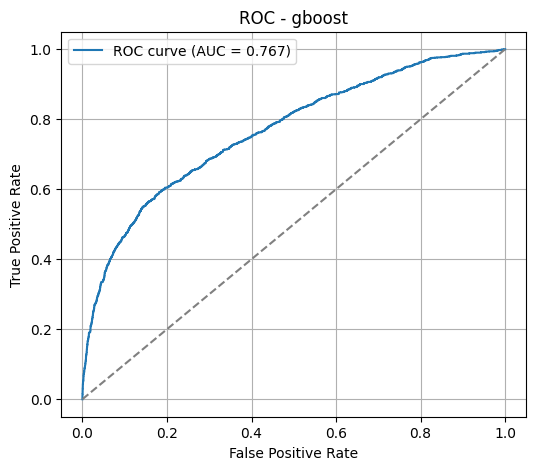

Confusion matrix:
 [[4103  570]
 [ 656  671]]

Classification report:
               precision    recall  f1-score   support

           0     0.8622    0.8780    0.8700      4673
           1     0.5407    0.5057    0.5226      1327

    accuracy                         0.7957      6000
   macro avg     0.7014    0.6918    0.6963      6000
weighted avg     0.7911    0.7957    0.7932      6000



In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Choose your best model (e.g., 'gboost' or 'RandomForest')
best_name = "gboost"
best_model = fitted_models[best_name]

# Predict probabilities and labels on test set
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC - {best_name}")
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix and classification report
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

In [0]:
# Choose your best model (you can change this)
best_model = fitted_models["gboost"]   # or "RandomForest", "LogisticRegression"

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

# Convert predictions to a DataFrame for display
import pandas as pd
pred_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

# Show first 20 predictions
display(pred_df.head(20))


Actual Predicted 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=4))


Confusion Matrix:
 [[4103  570]
 [ 656  671]]

Accuracy: 0.7956666666666666

Report:
               precision    recall  f1-score   support

           0     0.8622    0.8780    0.8700      4673
           1     0.5407    0.5057    0.5226      1327

    accuracy                         0.7957      6000
   macro avg     0.7014    0.6918    0.6963      6000
weighted avg     0.7911    0.7957    0.7932      6000



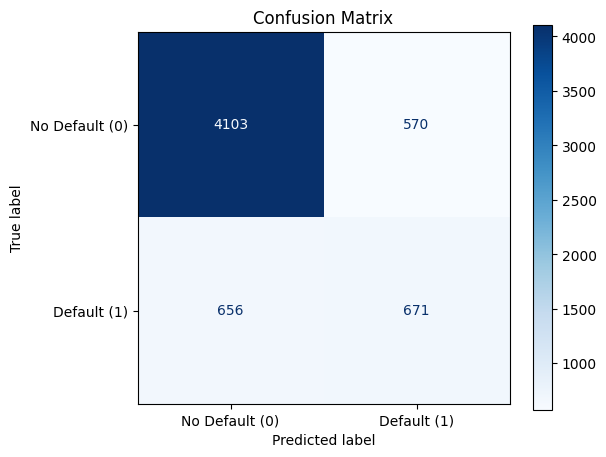

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default (0)","Default (1)"])
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


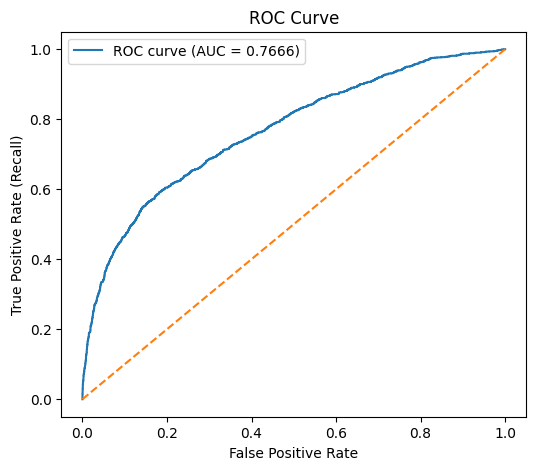

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = best_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()


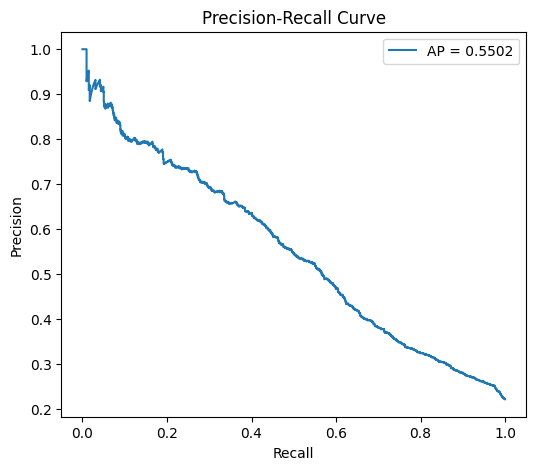

In [0]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP = {ap:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [0]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

thresholds_to_try = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
rows = []
for t in thresholds_to_try:
    y_pred_t = (y_proba >= t).astype(int)
    cm_t = confusion_matrix(y_test, y_pred_t)
    precision_t = precision_score(y_test, y_pred_t)
    recall_t = recall_score(y_test, y_pred_t)
    f1_t = f1_score(y_test, y_pred_t)
    rows.append({
        "threshold": t,
        "TN": cm_t[0,0], "FP": cm_t[0,1],
        "FN": cm_t[1,0], "TP": cm_t[1,1],
        "precision": precision_t, "recall": recall_t, "f1": f1_t
    })

df_thresh = pd.DataFrame(rows)
display(df_thresh.sort_values("threshold"))


threshold TN FP FN TP precision recall f1 0.1 123 4550 8 1319 0.22474016016357132 0.9939713639788997 0.3665925514174541 0.2 1056 3617 65 1262 0.2586595613855298 0.9510173323285607 0.40670319046084435 0.25 1744 2929 156 1171 0.28560975609756095 0.8824415975885456 0.431545973834531 0.3 2387 2286 249 1078 0.32045184304399527 0.8123587038432555 0.459603496056278 0.35 2985 1688 360 967 0.36421845574387945 0.7287113790504898 0.48568558513309895 0.4 3504 1169 474 853 0.4218595450049456 0.6428033157498116 0.5094057927739624 0.5 4103 570 656 671 0.540692989524577 0.5056518462697814 0.5225856697819314

In [0]:
t = 0.30
y_pred_adj = (y_proba >= t).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("Threshold:", t)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adj))
print("\nReport:\n", classification_report(y_test, y_pred_adj, digits=4))


Threshold: 0.3
Confusion Matrix:
 [[2387 2286]
 [ 249 1078]]

Report:
               precision    recall  f1-score   support

           0     0.9055    0.5108    0.6532      4673
           1     0.3205    0.8124    0.4596      1327

    accuracy                         0.5775      6000
   macro avg     0.6130    0.6616    0.5564      6000
weighted avg     0.7761    0.5775    0.6104      6000



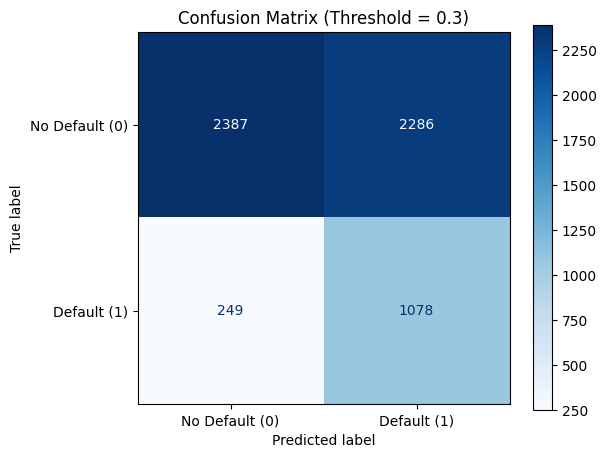


Classification Report:

              precision    recall  f1-score   support

           0     0.9055    0.5108    0.6532      4673
           1     0.3205    0.8124    0.4596      1327

    accuracy                         0.5775      6000
   macro avg     0.6130    0.6616    0.5564      6000
weighted avg     0.7761    0.5775    0.6104      6000



In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Step 1: Choose threshold
threshold = 0.3

# Step 2: Predict using new threshold
y_pred_adj = (y_proba >= threshold).astype(int)

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_adj)

# Step 4: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default (0)", "Default (1)"])
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

# Step 5 (optional): Print metrics for clarity
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_adj, digits=4))


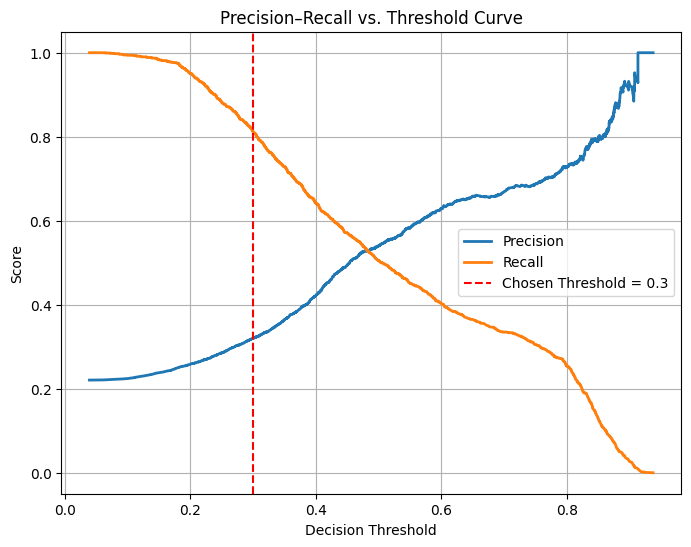

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot precision and recall vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], label="Recall", linewidth=2)

# Add vertical line for chosen threshold = 0.3
plt.axvline(x=0.3, color='red', linestyle='--', label='Chosen Threshold = 0.3')

# Labels and title
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs. Threshold Curve")
plt.legend()
plt.grid(True)
plt.show()


In [0]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Use your chosen threshold
threshold = 0.3

# Step 2: Generate adjusted predictions
y_pred_adj = (y_proba >= threshold).astype(int)

# Step 3: Create a DataFrame showing Actual vs Predicted
pred_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_adj,
    "Probability(Default)": y_proba
})

# Step 4: Display top predictions
display(pred_df.head(20))  # Databricks-native table view

# Step 5 (Optional): Print performance summary
print(f"Classification Report at threshold = {threshold}")
print(classification_report(y_test, y_pred_adj, digits=4))

# Step 6 (Optional): Show confusion matrix counts
cm = confusion_matrix(y_test, y_pred_adj)
print("Confusion Matrix:\n", cm)


Actual Predicted Probability(Default) 0 0 0.2945527313342476 0 0 0.29298926834691835 0 1 0.40463456307278417 1 0 0.17244055082399842 0 0 0.08390516233572327 0 1 0.5851231828624592 0 0 0.23758761789075303 0 0 0.09105249396697754 0 0 0.22277117739710342 0 0 0.23281686694856124 0 1 0.4939578912316143 0 1 0.41813170669938804 1 1 0.4202920446058074 0 0 0.22276517948165847 0 0 0.227472131209031 0 1 0.7485485593587504 0 0 0.07403700225512652 1 1 0.439035494493054 0 0 0.1876580645883517 0 0 0.23533210077378322

Classification Report at threshold = 0.3
              precision    recall  f1-score   support

           0     0.9055    0.5108    0.6532      4673
           1     0.3205    0.8124    0.4596      1327

    accuracy                         0.5775      6000
   macro avg     0.6130    0.6616    0.5564      6000
weighted avg     0.7761    0.5775    0.6104      6000

Confusion Matrix:
 [[2387 2286]
 [ 249 1078]]


In [0]:
# Reconstruct feature names
feature_cols = numeric_cols + [f"{c}_ohe" for c in cat_cols]
best_name = "RandomForest"  # or "gboost" if using XGBoost
if best_name in ["RandomForest", "XGBoost", "RandomForestClassifier", "XGBClassifier"]:
    best_model = fitted_models[best_name]
    fi_list = best_model.feature_importances_
    
    top_n = 20
    idx_sorted = np.argsort(fi_list)[::-1][:top_n]
    
    print("Top feature indices (index:importance):")
    for idx in idx_sorted:
        print(f"{idx}: {round(fi_list[idx], 4)}")
else:
    print("Feature importance extraction is best supported for tree-based models.")

Top feature indices (index:importance):
5: 0.111
3: 0.0787
4: 0.0618
17: 0.0509
11: 0.0501
18: 0.0486
22: 0.0482
12: 0.0458
6: 0.045
19: 0.0449
21: 0.0442
13: 0.0436
16: 0.0432
20: 0.0429
14: 0.0424
15: 0.0422
10: 0.0286
7: 0.0286
8: 0.0263
1: 0.025


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff6dfc1e1440>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


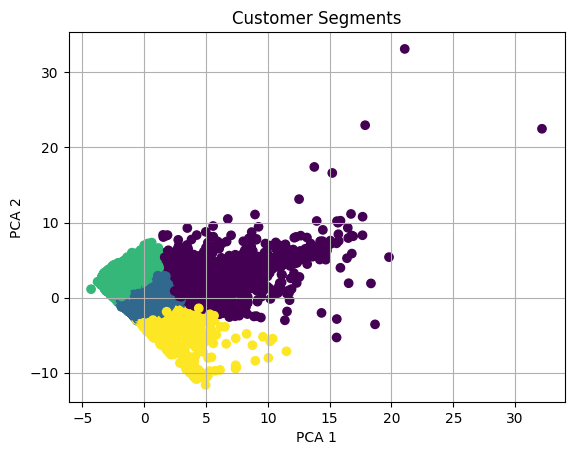

In [0]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Use original (unlabeled) features for clustering
X_cluster = StandardScaler().fit_transform(X)  # or use X_train_scaled

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

# Cluster customers
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

# Visualize clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("Customer Segments")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [0]:
from sklearn.ensemble import IsolationForest

# Train unsupervised anomaly detector
iso_forest = IsolationForest(contamination=0.01, random_state=42)
anomaly_scores = iso_forest.fit_predict(X_train_scaled)

# -1 = anomaly, 1 = normal
print("Anomalies detected in training set:", np.sum(anomaly_scores == -1))

Anomalies detected in training set: 240


In [0]:
# Assume you have a 'recovery_likelihood' label (1 = likely to repay after default)
# Train a model to prioritize collections
from sklearn.ensemble import RandomForestClassifier

recovery_model = RandomForestClassifier(random_state=42)
recovery_model.fit(X_train_smote, y_train_smote)

# Predict likelihood of repayment
repay_proba = recovery_model.predict_proba(X_test_scaled)[:, 1]

# Rank borrowers by likelihood
recovery_df = pd.DataFrame({
    "repay_probability": repay_proba,
    "actual_label": y_test
})
recovery_df_sorted = recovery_df.sort_values(by="repay_probability", ascending=False)
print(recovery_df_sorted.head(10))  # Top borrowers to prioritize

      repay_probability  actual_label
1752               1.00             1
5028               1.00             0
3171               1.00             1
5461               1.00             1
2695               1.00             1
858                1.00             1
3909               1.00             1
2209               1.00             1
2587               0.99             1
2490               0.99             1


In [0]:
import joblib
from sklearn.pipeline import Pipeline

# Build pipeline
credit_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=42))
])

# Fit and save model
credit_pipeline.fit(X_train, y_train)
joblib.dump(credit_pipeline, "credit_scoring_pipeline.pkl")

# Later: Load and score new applicants
# loaded_pipeline = joblib.load("credit_scoring_pipeline.pkl")
# new_scores = loaded_pipeline.predict_proba(new_applicant_data)[:, 1]

['credit_scoring_pipeline.pkl']